# Model Finetuning

This notebook explains how to use the fine-tuning function of an FaultDetector on the example use-case of transfer learning, demonstrated on the [CARE to Compare dataset](https://doi.org/10.5281/zenodo.14958989).

In [1]:
from energy_fault_detector.fault_detector import Config, FaultDetector
from energy_fault_detector.evaluation import Care2CompareDataset
from energy_fault_detector.utils.visualisation import plot_score_with_threshold

# Fine-tuning the full FaultDetector

In [2]:
# Specify the path to the data
data_path = '../../CARE_To_Compare_v5'
c2c = Care2CompareDataset(path=data_path)

config = Config(config_filename='c2c_configs/windfarm_C.yaml')
# update features to exclude (counters) and angles for data preprocessing
c2c.update_c2c_config(config=config, wind_farm='C')

# select two events from different assets
event_id = 44  # anomaly event of asset_id 44
event_info_1 = c2c.get_event_info(event_id=event_id)
train_sensor_data_1, train_status_1, test_sensor_data_1, test_status_1 = c2c.get_formatted_event_dataset(event_id=event_id, index_column='time_stamp')

event_id = 5  # anomaly event of asset_id 32
event_info_2 = c2c.get_event_info(event_id=event_id)
train_sensor_data_2, train_status_2, test_sensor_data_2, test_status_2 = c2c.get_formatted_event_dataset(event_id=event_id, index_column='time_stamp')

### Train and evaluate the AnomalyDetector for one event

In [3]:
model = FaultDetector(config=config)
train_results = model.fit(sensor_data=train_sensor_data_1, normal_index=train_status_1, save_models=True)
model_path = train_results.model_path

2025-07-03 13:09:17,593 - fault_detection - INFO - Initialize models..
2025-07-03 13:09:18,068 - fault_detection - INFO - Clip data before scaling.
2025-07-03 13:09:18,663 - fault_detection - INFO - Fit preprocessor pipeline.
2025-07-03 13:09:20,509 - fault_detection - INFO - Train autoencoder.
1643/1643 [==============================] - 1s 743us/step
2025-07-03 13:09:37,509 - fault_detection - INFO - Fit threshold on validation data
1643/1643 [==============================] - 1s 739us/step
2025-07-03 13:09:39,298 - fault_detection - INFO - Fit threshold.
2025-07-03 13:09:39,330 - fault_detection - INFO - Best F_0.5 score: 0.975, threshold: 4.53


327/327 [==============================] - 0s 647us/step


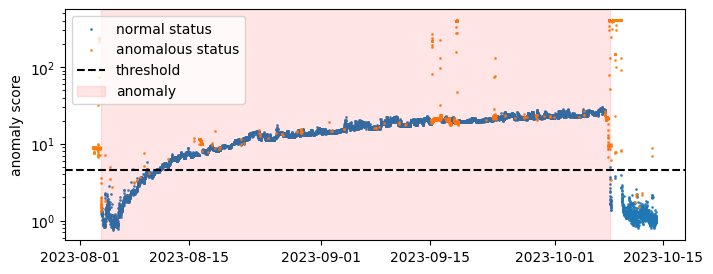

In [4]:
fig, ax = plot_score_with_threshold(model=model, data=test_sensor_data_1, normal_index=test_status_1)
ax.set_yscale('log')
ax.axvspan(event_info_1['event_start'], event_info_1['event_end'], alpha=0.1, color='red', label='anomaly')
ax.legend(loc='upper left')

### Fine tune on a small dataset from the other event

In [5]:
# take the last 3 months of data from event 2
num_time_stamps = 6 * 24 * 90
train_sensor_data_2 = train_sensor_data_2[-num_time_stamps:]
train_status_2 = train_status_2[-num_time_stamps:]

tune_model = FaultDetector()
tune_model.load_models(model_path=model_path)
tune_model.tune(sensor_data=train_sensor_data_2, normal_index=train_status_2, tune_epochs=10, tune_method='full', new_learning_rate=1e-4, save_models=False)

2025-07-03 13:09:41,543 - fault_detection - INFO - No configuration set - load models and config from path with the `load_models` method.
405/405 [==============================] - 0s 764us/step
2025-07-03 13:09:45,592 - fault_detection - INFO - Fit threshold on validation data
384/384 [==============================] - 0s 780us/step
2025-07-03 13:09:46,051 - fault_detection - INFO - Fit threshold.
2025-07-03 13:09:46,056 - fault_detection - INFO - Best F_0.5 score: 0.917, threshold: 1.23


ModelMetadata(model_date='20250703_130946', model_path=None, train_recon_error=                     sensor_0_avg  sensor_1_avg  power_2_avg  sensor_3_avg  \
time_stamp                                                                   
2022-12-09 21:50:00      0.035972      0.002260     0.121919      0.010045   
2022-11-11 09:10:00     -0.063019     -0.026476    -0.001291     -0.333562   
2023-01-17 13:40:00     -0.027138     -0.030004    -0.101569     -0.458847   
2023-01-08 21:10:00     -0.536266      0.064568    -0.492855      0.066587   
2023-01-09 23:30:00     -0.281280      0.047700    -0.180169     -0.146808   
...                           ...           ...          ...           ...   
2022-12-26 05:40:00     -0.277438     -0.145211    -0.161332     -0.243531   
2022-12-29 08:10:00     -0.178642      0.042738    -0.118380     -0.131240   
2023-01-06 04:30:00     -0.331534     -0.001619    -0.282044     -0.124874   
2022-11-11 23:50:00     -0.033414     -0.088529     0.054986   

### Display the results on the second event from a different asset

21/21 [==============================] - 0s 793us/step


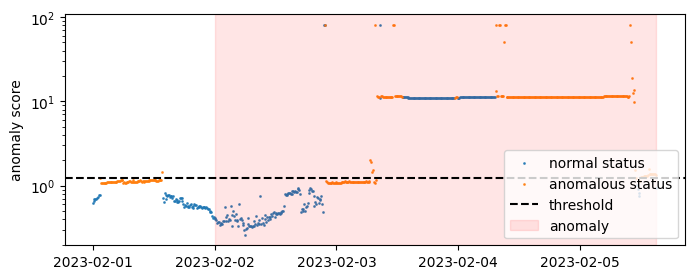

In [6]:
fig, ax = plot_score_with_threshold(model=tune_model, data=test_sensor_data_2, normal_index=test_status_2)
ax.set_yscale('log')
ax.axvspan(event_info_2['event_start'], event_info_2['event_end'], alpha=0.1, color='red', label='anomaly')
ax.legend(loc='lower right')

### Compare the original model performance

The original non-fine-tuned model can not reconstruct any of the normal data points well.

21/21 [==============================] - 0s 783us/step


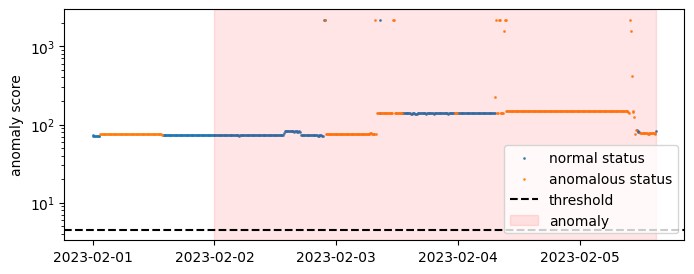

In [7]:
fig, ax = plot_score_with_threshold(model=model, data=test_sensor_data_2, normal_index=test_status_2)
ax.set_yscale('log')
ax.axvspan(event_info_2['event_start'], event_info_2['event_end'], alpha=0.1, color='red', label='anomaly')
ax.legend(loc='lower right')

### Additional comparison with the training data of the second event

405/405 [==============================] - 0s 994us/step


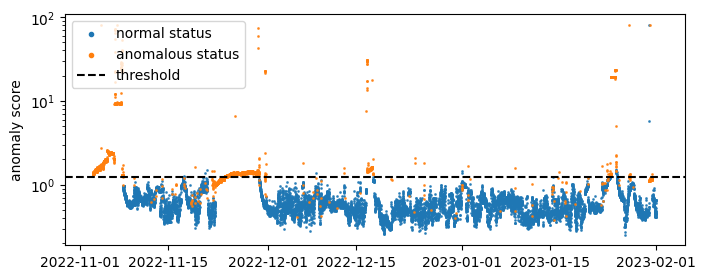

In [8]:
fig, ax = plot_score_with_threshold(model=tune_model, data=train_sensor_data_2, normal_index=train_status_2)
ax.set_yscale('log')

405/405 [==============================] - 0s 723us/step


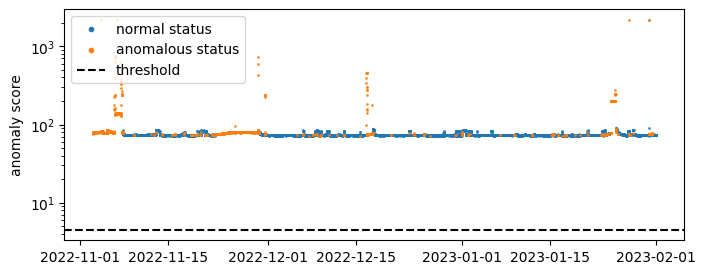

In [9]:
fig, ax = plot_score_with_threshold(model=model, data=train_sensor_data_2, normal_index=train_status_2)
ax.set_yscale('log')